In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import *
from utils.manifold_utils import *
from utils.pytorch3d import *

from flow_matching.utils.manifolds import Manifold, Sphere, Euclidean
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/quaternion.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 100001,
  'batch_size': 100,
  'inf_every': 4000,
  'print_every': 4000,
  'device': 'cpu',
  'inf_runs_num': 3,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 128, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 4,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 1.5,
  'downsample': 5,
  'sample_points': 300,
  'mean': 0.0,
  'std': 0.5},
 'ema': {'warmup': 2000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 10000, 'gamma': 0.5}}

In [4]:
manifold_types = {'None' : None, 'Euclidean': Euclidean(), 'Sphere':Sphere()}
val_sets=[0]
train_sets = list(range(1,7))
print(train_sets, val_sets)

[1, 2, 3, 4, 5, 6] [0]


In [5]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'],
                               rotate=True)

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))
print(gt_obs.shape)

7
1
6
torch.Size([1, 200, 9])


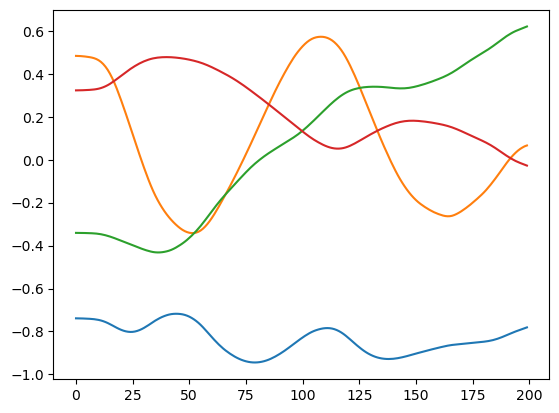

In [6]:
plt.plot(gt_obs[0,:,:4])
# plt.show()

In [7]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e

In [8]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(run_parameters['data']['datasets'])
)
ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 133944


In [9]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=False)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step(vf=vf, 
                              batch=batch, 
                              run_parameters=run_parameters, 
                              manifold=manifold, 
                              path=path, 
                              device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                plt.figure()
                plt.plot(train_losses, label='Training Loss')
                plt.plot(val_losses, label='Validation Loss')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(save_path,'loss_plot.png'))
                plt.close()

                plt.figure()
                plt.plot(lrs, label='Learning rate')
                plt.xlabel('Iterations (x print_every)')
                plt.ylabel('lr')
                plt.legend()
                plt.savefig(os.path.join(save_path,'lr_plot.png'))
                plt.close()
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step(vf=vf, 
                                    batch=val_batch, 
                                    run_parameters=run_parameters, 
                                    manifold=manifold, 
                                    path=path, 
                                    device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs)
                    plt.plot(infered['Sine']['results'][0])
                    plt.show()
                    # for label_name in infered.keys():
                    #     plot_flow_on_sphere(infered[label_name]['results'], 
                    #                         infered[label_name]['samples'], 
                    #                         gt_obs[dataset.get_label_maping()[label_name]],
                    #                         label=label_name)
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

| iter      0 |  0.08 sec | train loss    0.485 
| iter      0 | validation loss:    0.503 


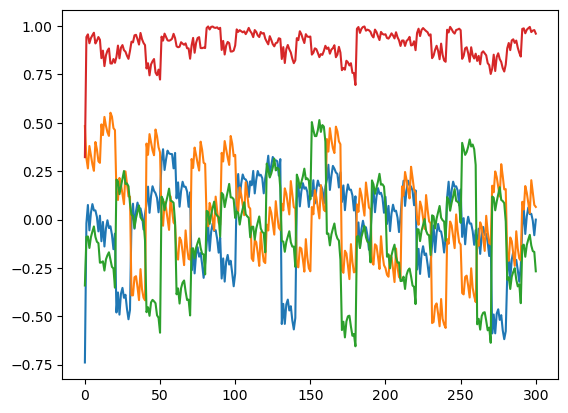

| iter   4000 | 53.42 sec | train loss    0.012 
| iter   4000 | validation loss:    0.011 


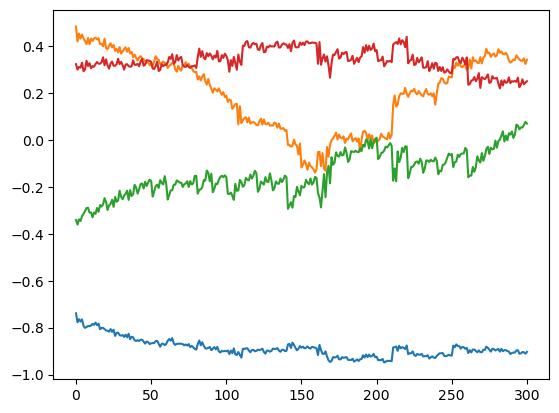

| iter   8000 | 58.04 sec | train loss    0.007 
| iter   8000 | validation loss:    0.008 


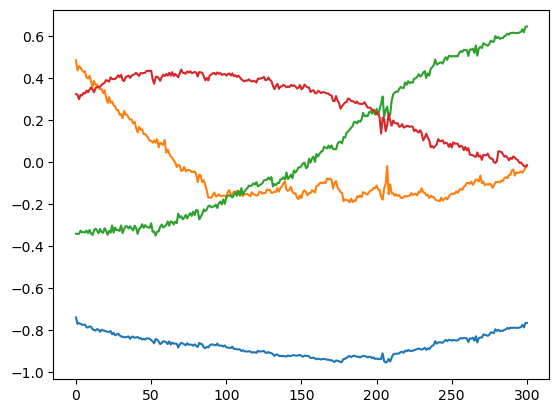

| iter  12000 | 57.50 sec | train loss    0.004 
| iter  12000 | validation loss:    0.004 


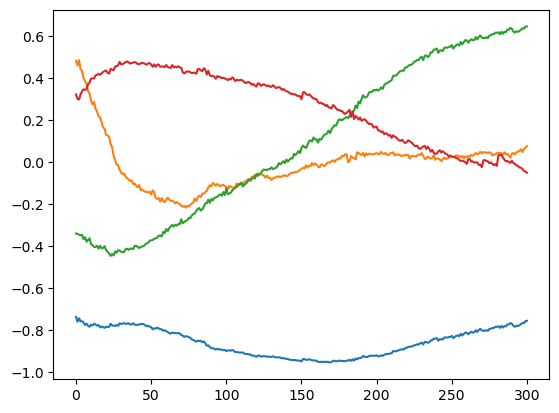

| iter  16000 | 58.29 sec | train loss    0.004 
| iter  16000 | validation loss:    0.003 


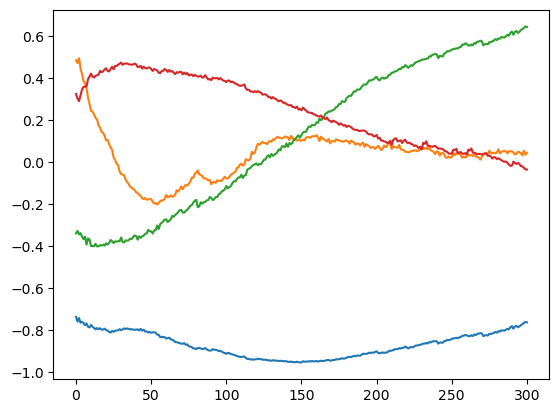

| iter  20000 | 57.66 sec | train loss    0.003 
| iter  20000 | validation loss:    0.004 


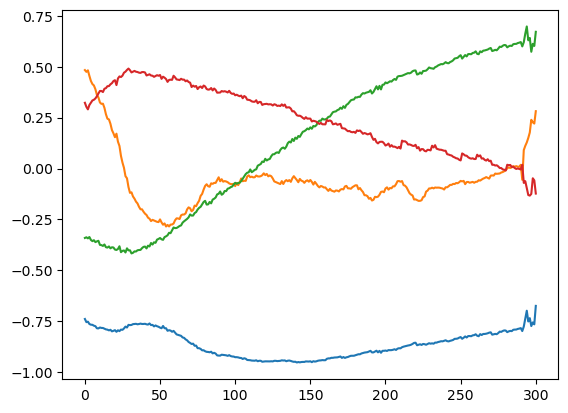

| iter  24000 | 55.56 sec | train loss    0.003 
| iter  24000 | validation loss:    0.002 


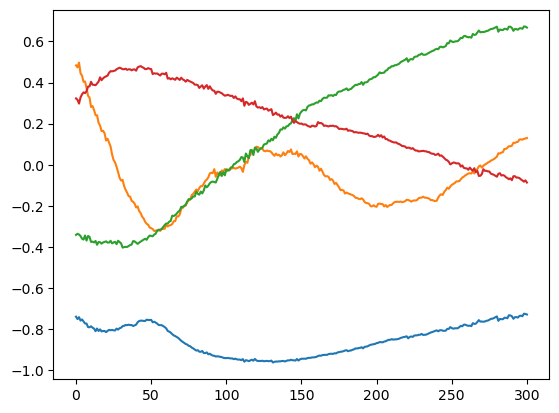

| iter  28000 | 57.38 sec | train loss    0.002 
| iter  28000 | validation loss:    0.004 


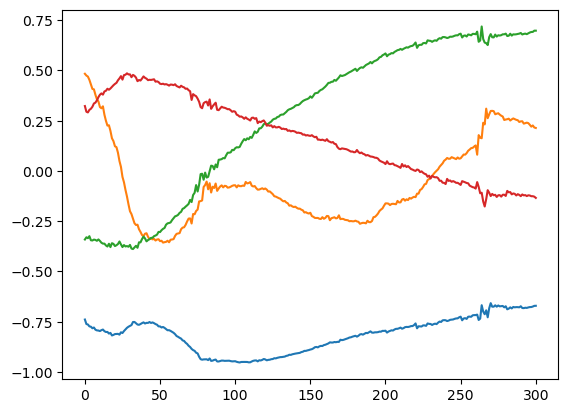

| iter  32000 | 58.96 sec | train loss    0.002 
| iter  32000 | validation loss:    0.002 


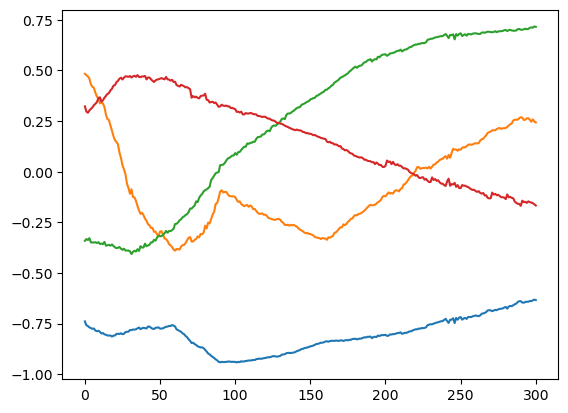

| iter  36000 | 60.35 sec | train loss    0.002 
| iter  36000 | validation loss:    0.003 


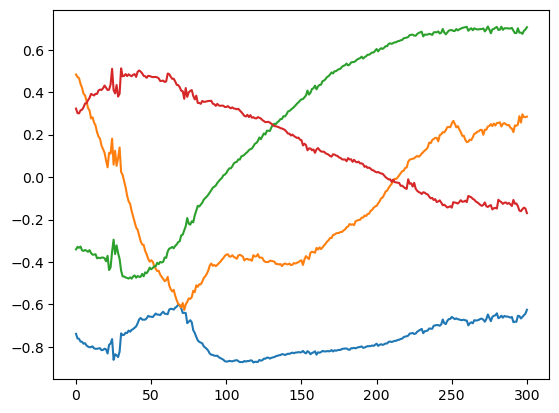

| iter  40000 | 59.95 sec | train loss    0.002 
| iter  40000 | validation loss:    0.002 


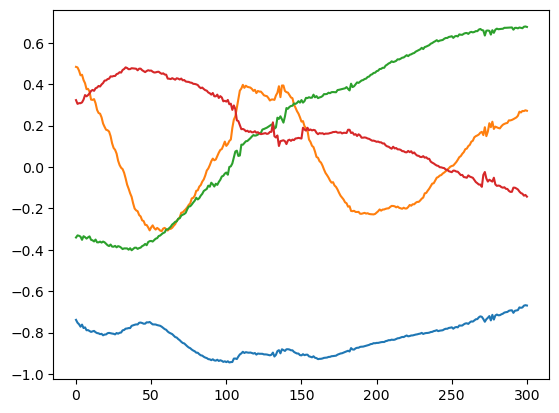

| iter  44000 | 58.26 sec | train loss    0.002 
| iter  44000 | validation loss:    0.002 


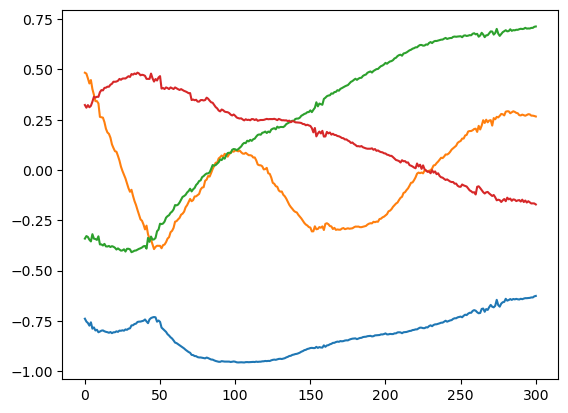

| iter  48000 | 63.91 sec | train loss    0.002 
| iter  48000 | validation loss:    0.004 


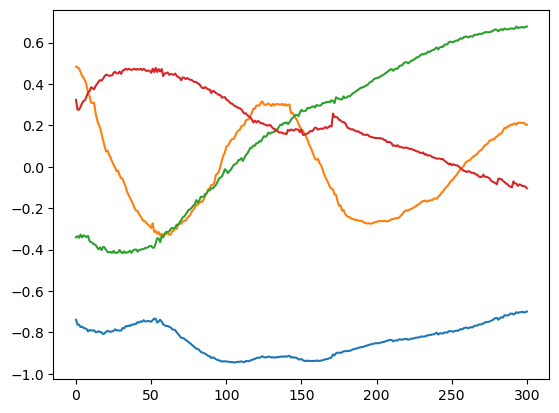

| iter  52000 | 55.39 sec | train loss    0.002 
| iter  52000 | validation loss:    0.002 


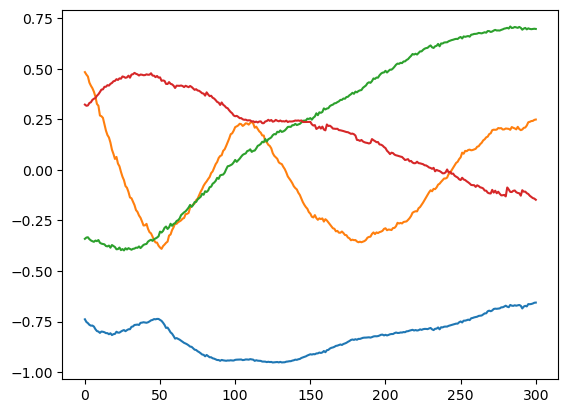

| iter  56000 | 49.05 sec | train loss    0.002 
| iter  56000 | validation loss:    0.004 


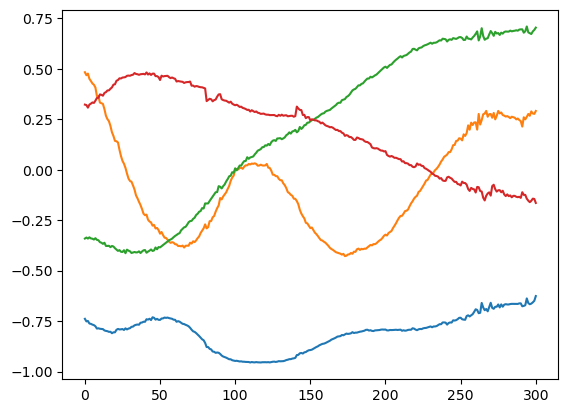

| iter  60000 | 47.22 sec | train loss    0.002 
| iter  60000 | validation loss:    0.003 


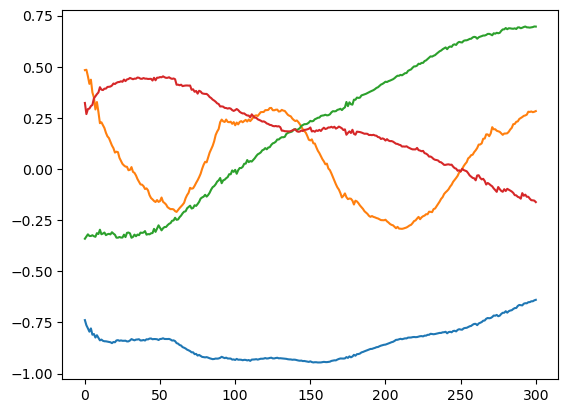

| iter  64000 | 47.30 sec | train loss    0.001 
| iter  64000 | validation loss:    0.003 


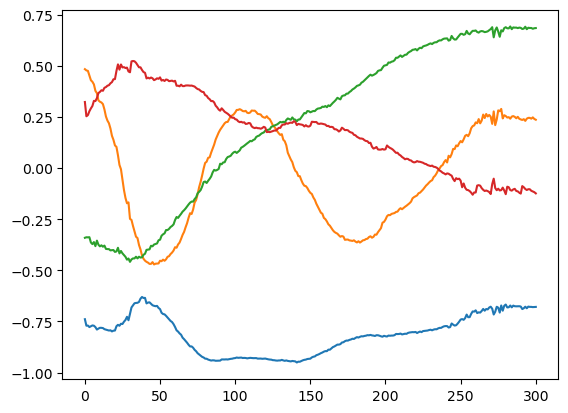

| iter  68000 | 45.13 sec | train loss    0.002 
| iter  68000 | validation loss:    0.002 


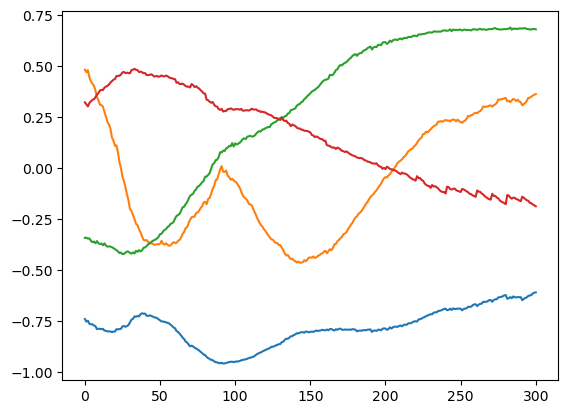

| iter  72000 | 48.13 sec | train loss    0.002 
| iter  72000 | validation loss:    0.003 


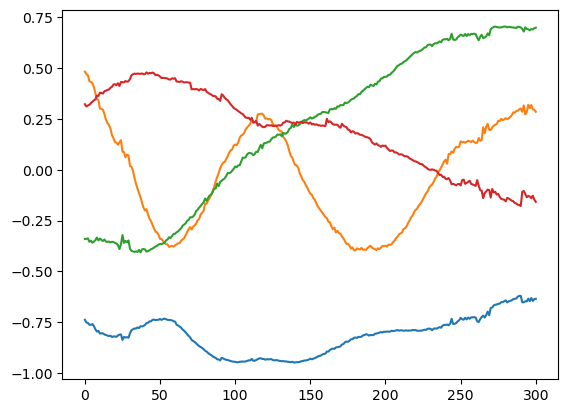

| iter  76000 | 49.77 sec | train loss    0.002 
| iter  76000 | validation loss:    0.001 


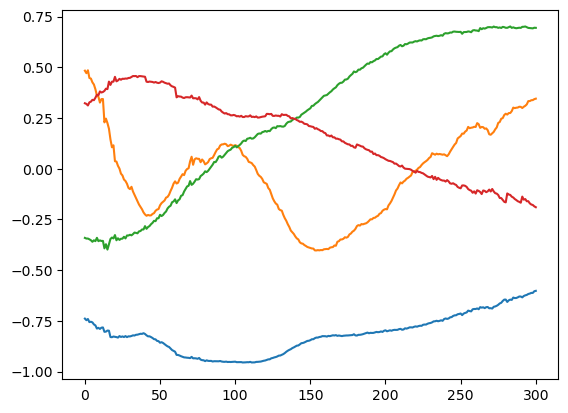

| iter  80000 | 47.18 sec | train loss    0.002 
| iter  80000 | validation loss:    0.002 


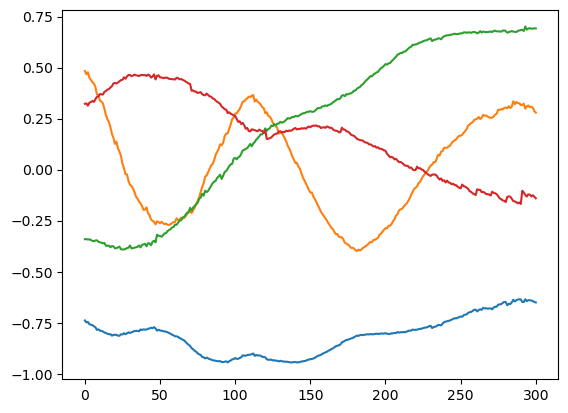

| iter  84000 | 52.94 sec | train loss    0.002 
| iter  84000 | validation loss:    0.002 


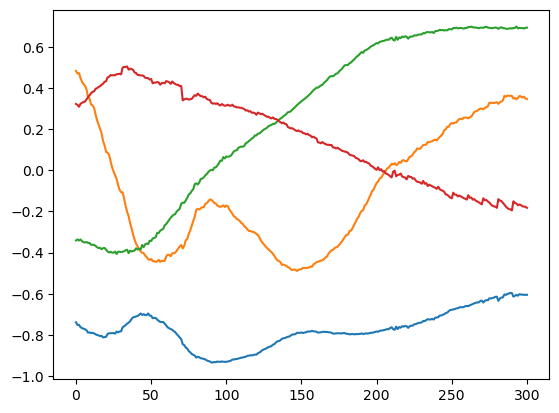

| iter  88000 | 48.75 sec | train loss    0.002 
| iter  88000 | validation loss:    0.001 


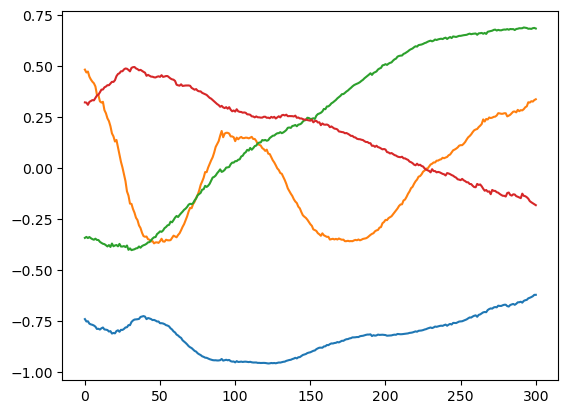

| iter  92000 | 47.43 sec | train loss    0.002 
| iter  92000 | validation loss:    0.002 


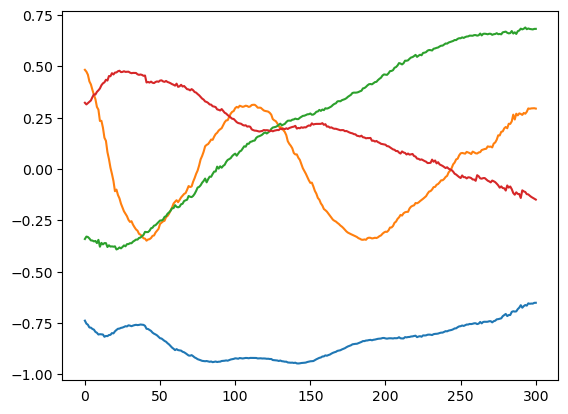

| iter  96000 | 46.57 sec | train loss    0.002 
| iter  96000 | validation loss:    0.002 


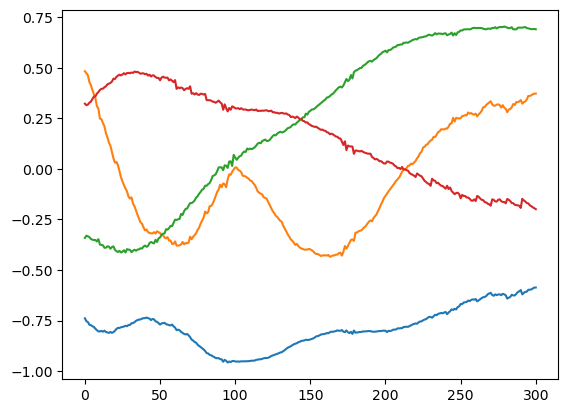

| iter 100000 | 45.97 sec | train loss    0.002 
| iter 100000 | validation loss:    0.002 


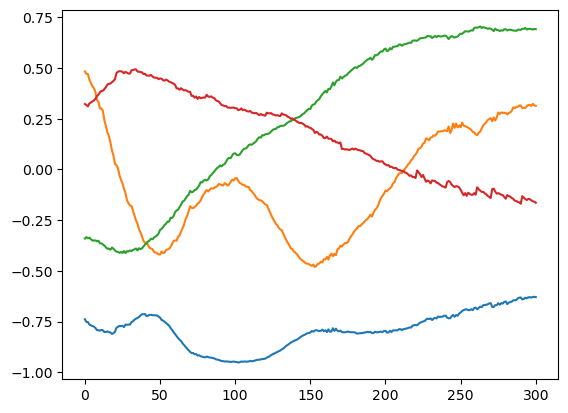

In [10]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="sine_shape_S3")

In [15]:
infered = run_inference(manifold=manifold,
                        model=vf,
                        run_parameters=run_parameters,
                        class_labels=dataset.get_label_maping(),
                        gt_obs=gt_obs)

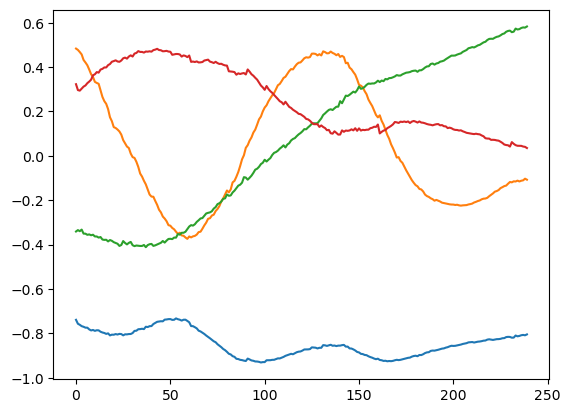

In [17]:
plt.plot(infered['Sine']['results'][0][:240])

# Quaternion Testing

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from mpl_toolkits.mplot3d import Axes3D

# === Quaternion utilities ===
def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ])

def quaternion_conjugate(q):
    q = np.array(q)
    return np.array([q[0], -q[1], -q[2], -q[3]])

def apply_quaternion(q, v):
    """Rotate 3D vector v by quaternion q."""
    q_v = np.concatenate([[0.0], v])
    return quaternion_multiply(
        quaternion_multiply(q, q_v),
        quaternion_conjugate(q)
    )[1:]  # return vector part

# === Create sample quaternion sequence ===
# Replace this with your actual data: quaternions of shape [n, 4]
n = 100
angles = np.linspace(0, 2 * np.pi, n)
quaternions = gt_obs[0,:,:4]

# === Visualization ===
def plot_quaternion_rotation(i):
    q = quaternions[i]
    v0 = np.array([1, 0, 0])  # original vector
    v_rot = apply_quaternion(q, v0)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Draw original and rotated vectors
    ax.quiver(0, 0, 0, *v0, color='blue', label='Original')
    ax.quiver(0, 0, 0, *v_rot, color='red', label='Rotated')

    # Draw unit sphere for context
    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_wireframe(x, y, z, color="lightgray", linewidth=0.5, alpha=0.5)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"Quaternion index: {i}")
    ax.legend()
    plt.show()

# === Interactive slider ===
interact(plot_quaternion_rotation, i=IntSlider(min=0, max=n-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

In [34]:
print(((gt_obs[0,:,:4])**2).sum(axis=1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [35]:
obs_mat = quaternion_to_matrix(gt_obs[0,:,:4])
quat_back = matrix_to_quaternion(obs_mat)

In [36]:
print(gt_obs[0,:,:4] + quat_back)

tensor([[ 5.9605e-08,  8.9407e-08, -8.9407e-08,  8.9407e-08],
        [-5.9605e-08, -1.1921e-07,  1.1921e-07, -5.9605e-08],
        [ 0.0000e+00, -2.9802e-08,  2.9802e-08, -2.9802e-08],
        [ 0.0000e+00, -2.9802e-08,  5.9605e-08,  0.0000e+00],
        [-5.9605e-08,  8.9407e-08, -2.9802e-08,  5.9605e-08],
        [-5.9605e-08, -2.9802e-08,  2.9802e-08, -2.9802e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 5.9605e-08,  0.0000e+00,  2.9802e-08, -2.9802e-08],
        [ 0.0000e+00, -5.9605e-08,  2.9802e-08, -2.9802e-08],
        [ 0.0000e+00, -1.1921e-07,  8.9407e-08, -5.9605e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -5.9605e-08,  2.9802e-08, -2.9802e-08],
        [-5.9605e-08, -5.9605e-08,  2.9802e-08, -2.9802e-08],
        [-5.9605e-08,  5.9605e-08,  0.0000e+00,  2.9802e-08],
        [-5.9605e-08, -2.9802e-08, -2.9802e-08,  0.0000e+00],
        [ 5.9605e-08,  0.0000e+00,  0.0000e+00, -2.9802e-08],
        